<a href="https://colab.research.google.com/github/dataista0/prueba-humai/blob/main/anomaly-detection-shap-values.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>
<div align="center"> Recordá abrir en una nueva pestaña </div>

<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/MachineLearning/8_ShapyAnomalias/anomaly-detection-shap-values.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>
<div align="center"> Recordá abrir en una nueva pestaña </div>

# Detección de anomalías y explicabilidad de modelos con valores SHAP

#### Tabla de Contenidos

1) Importar dependencias, definir los parámetros y explorar los datos.

2) Detección de anomalías: métodos univariados y multivariados.

3) Explicabilidad de modelos: desempeño versus parsimonia, técnicas de subrogación, valores SHAP.

## 1) Importar dependencias, explorar los datos y definir los parámetros

Utilizo el _magic command_ `bash` (ver más [aquí](https://ipython.readthedocs.io/en/stable/interactive/magics.html) para instalarlas las dependencias).

In [1]:
%%bash

# Nota: se modifico esta linea para instalar las versiones mas nuevas de las librerias
pip3 install --upgrade matplotlib numpy pandas sklearn xgboost seaborn shap

  Using cached numpy-1.23.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)


Importo las dependencias instaladas.

In [2]:
%matplotlib inline

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import shap
from IPython import display
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

shap.initjs()

Defino parámetros de semilla y el estilo de los graficos y los valores de punto flotante.

In [3]:
sns.set_style("ticks")
sns.set_context("paper")

seed = 1234
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

Cargo el conjunto de datos desde la instancia de Colab. En este caso usaremos el mismo que para la clase de XGBoost, el [Adult de la UCI](https://archive.ics.uci.edu/ml/datasets/Adult). En caso de no estar disponible (por ejemplo, la primera vez que se ejecuta el código) se lo descarga desde el repositorio público de Humai. 

In [4]:
try:
    data = pd.read_csv("adult_train.csv")
except:
    data = pd.read_csv("https://datasets-humai.s3.amazonaws.com/datasets/adult_train.csv")
    data.to_csv("adult_train.csv", index = False)

Analizo los datos, comenzando por los primeros registros y siguiendo por la distribución de las variables cuantitativas y la variable objetivo.

In [5]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
data.describe().astype(int)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561,32561,32561,32561,32561,32561
mean,38,189778,10,1077,87,40
std,13,105549,2,7385,402,12
min,17,12285,1,0,0,1
25%,28,117827,9,0,0,40
50%,37,178356,10,0,0,40
75%,48,237051,12,0,0,45
max,90,1484705,16,99999,4356,99


La variable objetivo `target` define si una persona tenía un ingreso anual superior a los 50 mil dólares estadounidenses al momento de ser relevada la información.

In [7]:
data.target.value_counts()

<=50K    24720
>50K      7841
Name: target, dtype: int64

In [8]:
data.target.value_counts(normalize=True).round(2)

<=50K    0.76
>50K     0.24
Name: target, dtype: float64

Reemplazamos las categorías de la variable objetivo por valores binarios.

Normalizamos los datos utilizando la estandarización de `scikit-learn`

In [9]:
numeric_data = data[["education-num", "capital-gain", "capital-loss", "hours-per-week"]]

In [10]:
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(numeric_data), 
                           columns = numeric_data.columns)

## 2) Detección de anomalías

Para tener una primera aproximación es útil estandarizar el conjunto de datos -las variables cuantitativas- y graficarlas usando un _boxplot_. Así, podemos tener rápidamente una idea de la cardinalidad de las variables y la cantidad de _outliers_ potenciales, a quienes podemos definir como puntos por fuera de los "bigotes" del _boxplot_. Si lo pensamos en términos de desvíos estándar, en este caso los "bigotes" comprenden 3 desvíos para sólo graficar por fuera puntos que están realmente lejos.

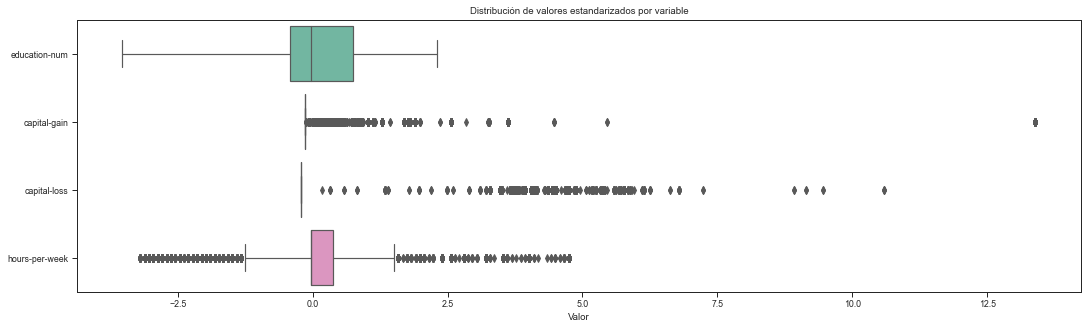

In [11]:
data_boxplot = sns.boxplot(data = scaled_data, orient = "h", palette = "Set2", whis = 3)
plt.title("Distribución de valores estandarizados por variable")
plt.xlabel("Valor")
data_boxplot.figure.set_size_inches(18,5)

Para analizar los _outliers_ puedo evaluar cuántos puntos se ubican a más de 3 veces el rango intercuartil (IQR) con una técnica conocida como [Tukey's fences](https://en.wikipedia.org/wiki/Outlier#Tukey%27s_fences). Si bien estos puntos son probablemente _outliers_, siempre es importante tener en cuenta el dominio de análisis.

### Ejercicio 1: Calcular el IQR para al menos dos variables del conjunto de datos

Para facilitar el análisis -y no tener que hacerlo nosotros- vamos a utilizar el mismo conjunto de datos pero tomándolo desde su versión previamente categorizada en la librería `shap`.

In [12]:
numeric_data,y = shap.datasets.adult()

In [13]:
numeric_data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


### Isolation Forest

La técnica de detección de anomalías conocida como Isolation Forest es muy útil para detectar _outliers_ multivariados. Es un método similar al de _Random Forest_ y funciona mediante la selección aleatoria de particiones de variables aleatorias. Dado que los _outliers_ son menos frecuentes que las observaciones normales, el método asume para calcular su _score_ que debieran estar más cerca de la raíz del árbol (dado que residen en regiones dispersas -ralas- del espacio de variables).

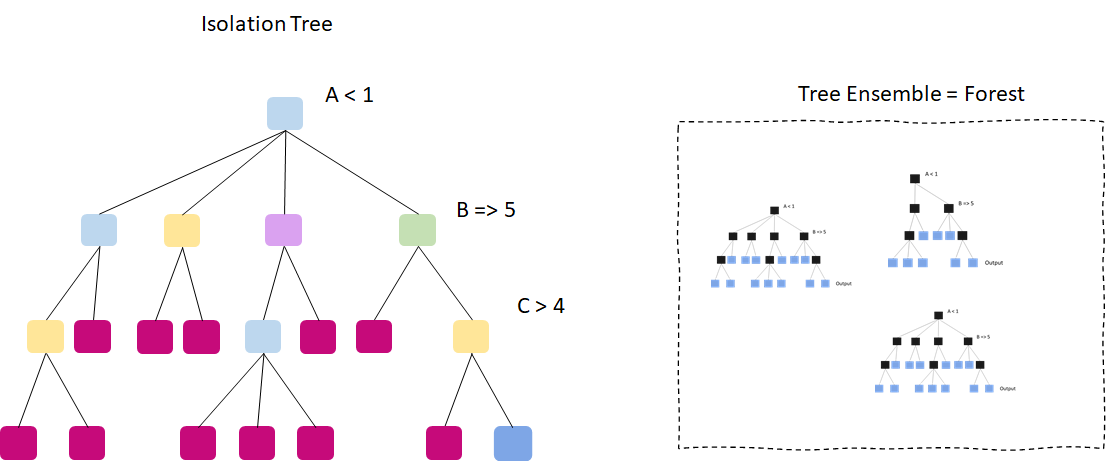

In [14]:
display.Image("https://www.relataly.com/wp-content/uploads/2021/06/image-40.png")



En términos formales, el valor de la probabilidad de que un registro sea anomalo está dado por la siguiente ecuación:

## $s(x_i, N) = 2 ^ \frac{-E(h(x_i))}{c(N)}$

donde $s$ es el score, $x_i$ es la observación, $E(h(x_i))$ es el promedio de longitud de los caminos y $c(N)$ es la longitud promedio de una búsqueda no exitosa en un árbol binario (BST, por su acrónimo en inglés).

Dado que la construcción de este modelo es similar a un árbol binario de búsqueda, por estar basada en selecciones de atributos y particiones aleatorias, podemos aproximar el camino promedio de un nodo con la búsqueda no exitosa en un árbol binario. Es por este motivo que tomamos el término $c(N)$ como referencia. 

Como puede deducirse de la función detallada, mientras más se diferencie el promedio de longitud de los caminos con el de las búsquedas no exitosas más alta va ser la probabilidad de anomalía.

#### Entrenar un modelo y predecir valores anómalos

Lo primero que vamos a hacer es analizar los parámetros más relevantes.

In [15]:
iso_forest = IsolationForest(max_samples = "auto", contamination = "auto", random_state = seed)

In [16]:
iso_forest.fit(numeric_data)

IsolationForest(random_state=1234)

In [17]:
outlier_pred = iso_forest.predict(numeric_data)
outlier_pred = [False if x == 1 else True for x in outlier_pred]

In [18]:
data[outlier_pred].head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
11,30,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,>50K
14,40,Private,121772,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,?,>50K
15,34,Private,245487,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,Amer-Indian-Eskimo,Male,0,0,45,Mexico,<=50K


### Ejercicio 2: compararlo con la distribución de la variable "Education-Num"

Los métodos multivariados de detección de anomalías son útiles también para encontrar patrones en la clase minoritaria que nos permitan mejorar la representación de la información.

## 3) Explicabilidad de modelos

Uno de los libros más relevantes para profundizar en el dominio de la interpretabilidad es [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/) de Christoph Molnar. Allí se enumeran distintos tipos de interpretaciones que se pueden categorizar en 3 grupos: 

1) Modelos interpretables
- Regresión lineal, logística, modelos lineales generalizados, árboles
2) Métodos agnósticos de los modelos
- PDP, ICE, ALE, Feature Importance, modelos surrogados, LIME, SHAP
3) Explicaciones basadas en ejemplos
- Contrafácticas, adversarias

#### Creación del conjunto para entrenar
Vamos a cargar el mismo conjunto de datos pero desde la librería `SHAP`

In [19]:
X,y = shap.datasets.adult()

X_display,y_display = shap.datasets.adult(display=True)

Dividimos en entrenamiento y validación

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

#### Entrenamiento de modelo de extreme gradient boosting (XGBoost)

La técnica de XGBoost fue explicada en clases anteriores. Aquí modelaremos usando un conjunto no optimizado de hiperparámetros, con cien iteraciones y _early stopping_.

In [21]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [22]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}

model_xgboost = xgb.train(params, dtrain, 1000, evals = [(dtest, "test")], 
                          verbose_eval=100, early_stopping_rounds=100)

[0]	test-logloss:0.54187
[100]	test-logloss:0.36809
[200]	test-logloss:0.32532
[300]	test-logloss:0.30923
[400]	test-logloss:0.30133
[500]	test-logloss:0.29741
[600]	test-logloss:0.29483
[700]	test-logloss:0.29343
[800]	test-logloss:0.29246
[900]	test-logloss:0.29175
[999]	test-logloss:0.29153


#### Feature importance

Antes de evaluar los valores Shapley utilizando la librería `SHAP` analizaremos la métrica de importancia de atributos con la que cuenta XGBoost. Hay tres maneras de evaluarla: peso (weight), ganancia (gain) y cobertura (coverage).

1) El peso refiere a la cantidad de veces que un atributo aparece en un árbol.

2) La ganancia representa a la ganancia promedio de los cortes que utilizan el atributo. 

3) La cobertura refiere a la cobertura -cantidad de registros afectados- promedio de las divisiones que usan el atributo.

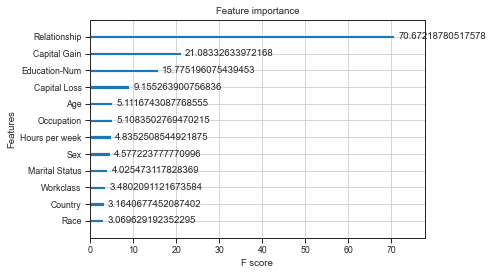

In [23]:
xgb.plot_importance(model_xgboost, importance_type="gain")
plt.show()

### SHAP

La librería [`SHAP`( SHapley Additive exPlanations)](https://shap.readthedocs.io/en/latest/index.html) utiliza los valores Shapley, provenientes de la teoría de juegos, para explicar el comportamiento de los modelos. 
En este caso, al contar con un modelo basado en árboles, utilizaremos la función `TreeExplainer()`.

_Nota: se realizaron una serie de modificaciones y agregados desde la grabación de la clase teórica online en lo que sigue. Las mismas están debidamente mencionadas en el código_

In [24]:
explainer = shap.TreeExplainer(model_xgboost)

# Nota: bugfix. Usaba dtrain y eso dejaba desalineado X_display con los shap_values
shap_values = explainer.shap_values(X)

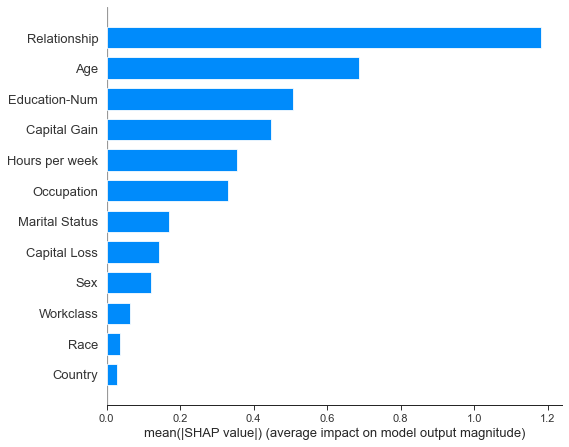

In [28]:
shap.summary_plot(shap_values, X_display, plot_type="bar")

#### Explicación de un solo ejemplo con `force_plot` (gráfico de fuerzas)

* El gráfico de fuerzas muestra los shap values de una manera intuitiva, como flechas de fuerza "empujando" la predicción original (_base value_) hacia la predicción final (_f(x)_). 

* El color rojo significa **impacto positivo** (aumento en las probabilidades de tener >50K) 
* El color azul significa **impacto negativo** (reducción en las probabilidad de tener >50K).

_Nota: Se agregó la opción `link="logit"` para mostrar los valores en términos de probabilidades y no de logits. Se agregó también la observación del ejemplo que está a continuación_

In [25]:
# Modificar para observar otras filas del dataset
i = 10

shap.force_plot(base_value=explainer.expected_value, 
                shap_values=shap_values[i,:], 
                features=X_display.iloc[i,:], 
                link="logit")

In [26]:
# Acá observamos el ejemplo anterior, los valores que toma cada uno de sus características
# Y el Shap value asociado a esta que dicha característica tome dicho valor.
sample = X_display.iloc[[i]].T
sample['Shap Values'] = shap_values[i].round(2)
sample['Shap Values Abs'] = sample['Shap Values'].abs()
sample.sort_values('Shap Values Abs', ascending=False).drop('Shap Values Abs', axis=1)

,10,Shap Values
Relationship,Husband,0.87
Hours per week,80.0,0.72
Occupation,Exec-managerial,0.46
Age,37.0,0.29
Capital Gain,0.0,-0.19
Workclass,Private,0.14
Marital Status,Married-civ-spouse,0.09
Race,Black,-0.08
Capital Loss,0.0,-0.08
Education-Num,10.0,-0.06


In [27]:
# base_value: la predicción promedio del modelo, o bias
# El grafico de fuerzas muestra cuanto se aparta una predicción de la media general
model_xgboost.predict(dtrain).mean().round(4)

0.2431

#### Otro tipo de summary plot: beeswarm

El beeswarm muestra:
* La distribución de los datos para cada característica
* El impacto del valor que toma una característica sobre el resultado

_Nota: agregado en 2022_

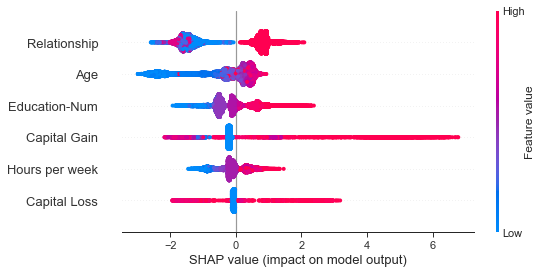

In [34]:
# Age, Education-Num, Relationship, Capital Gain, Capital Loss, Hours per week
cols = [0, 2, 5, 8, 9, 10]
shap.summary_plot(shap_values[:, cols], X.iloc[:, cols])

#### Gráficos de dependencias

Los gráficos de dependencia muestran el efecto de un atributo específico a través de todo el conjunto de datos. Contrastan su valor con el valor SHAP de dicho atributo a través de muchos registros. Si bien son similares a los _Partial Dependency Plots_ (PDP), toman además en cuenta las interacciones entre los atributos, que se evidencia en la dispersión vertical en un determinado valor y en el color de la variable elegida a tal fin.

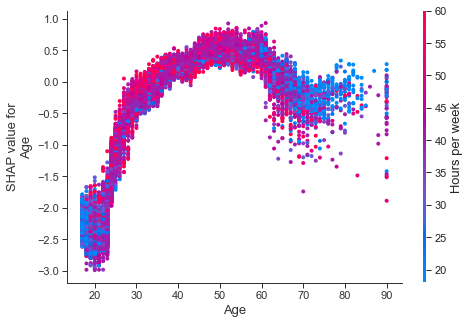

In [31]:
# Nota: Modificamos los gráficos de dependencias desde la teórica grabada
shap.dependence_plot('Age', shap_values, X, 
                     display_features=X_display, interaction_index=10)

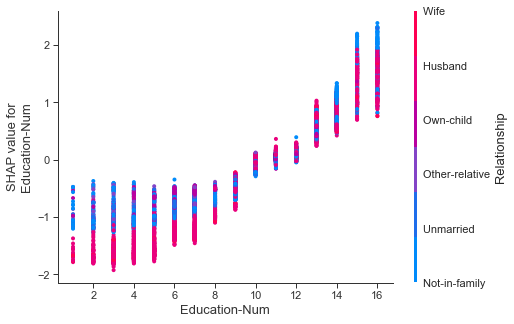

In [32]:
shap.dependence_plot('Education-Num', shap_values, X, 
                     display_features=X_display, interaction_index=5)

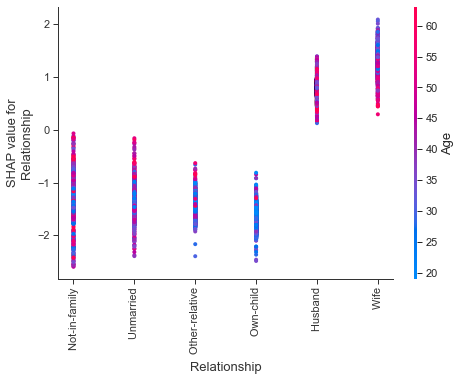

In [33]:
shap.dependence_plot('Relationship', shap_values, X, 
                     display_features=X_display, interaction_index=0)

### Próximos pasos:

- Las técnicas de detección de anomalías pueden ser utilizadas para detectar patrones en los comportamientos de las clases minoritarias (en este caso, aquellas personas con un ingreso anual mayor a USD50 mil).

- Se pueden aplicar técnicas de _clustering_ a los valores de Shapley para evaluar el potencial de ingresos, en línea con lo mencionado sobre los patrones que se pueden detectar. Este tipo de _clustering_ supervisado es una alternativa interesante para validar la pertinencia de los valores.